In [11]:
# === 1. Import Library ===
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import shutil

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [12]:
# === 2. Atur Path Dataset Asli dan Bikin Folder Train/Val Otomatis ===
BASE_DIR = "/home/fordidodi/Documents/GitHub/Project-AI"
DATASET_DIR = os.path.join(BASE_DIR, "dataset")
SPLIT_DIR = os.path.join(BASE_DIR, "dataset_split")
TRAIN_DIR = os.path.join(SPLIT_DIR, "train")
VAL_DIR = os.path.join(SPLIT_DIR, "val")

# Buat folder train/val kosong
if os.path.exists(SPLIT_DIR):
    shutil.rmtree(SPLIT_DIR)
os.makedirs(TRAIN_DIR)
os.makedirs(VAL_DIR)

# Bagi data per kelas (80% train, 20% val)
for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

        os.makedirs(os.path.join(TRAIN_DIR, class_name))
        os.makedirs(os.path.join(VAL_DIR, class_name))

        for img in train_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(TRAIN_DIR, class_name, img))
        for img in val_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(VAL_DIR, class_name, img))


In [15]:
# === 3. Image Generator + Augmentasi ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1104 images belonging to 3 classes.
Found 276 images belonging to 3 classes.


In [16]:
# === 4. Buat Model dengan MobileNetV2 ===
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Fine-tune nanti kalau perlu

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
preds = Dense(len(os.listdir(DATASET_DIR)), activation='softmax')(x)  # otomatis sesuai jumlah kelas

model = Model(inputs=base_model.input, outputs=preds)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [17]:
# === 5. Callback ===
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)

In [18]:
# === 6. Training ===
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop, lr_reduce]
)

/home/fordidodi/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 33s 775ms/step - accuracy: 0.5009 - loss: 1.1633 - val_accuracy: 0.7283 - val_loss: 0.6348 - learning_rate: 0.0010
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 486ms/step - accuracy: 0.6902 - loss: 0.7283 - val_accuracy: 0.7826 - val_loss: 0.5259 - learning_rate: 0.0010
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 467ms/step - accuracy: 0.7572 - loss: 0.5739 - val_accuracy: 0.8007 - val_loss: 0.4727 - learning_rate: 0.0010
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 478ms/step - accuracy: 0.7654 - loss: 0.5309 - val_accuracy: 0.8406 - val_loss: 0.4097 - learning_rate: 0.0010
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 501ms/step - accuracy: 0.8143 - loss: 0.4960 - val_accuracy: 0.8551 - val_loss: 0.3837 - learning_rate: 0.0010
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 486ms/step - accuracy: 0.8007 - loss: 0.4799 - val_accuracy: 0.8261 - val_loss: 0.3922 - learning_rate: 0.0010
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 485ms/step - accuracy: 0.8243 - loss: 0.

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.8768 - loss: 0.2916

Validation Accuracy: 0.8768
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 511ms/step


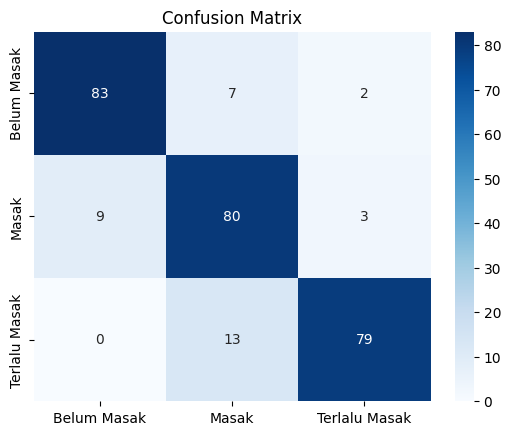


Classification Report:
               precision    recall  f1-score   support

  Belum Masak       0.90      0.90      0.90        92
        Masak       0.80      0.87      0.83        92
Terlalu Masak       0.94      0.86      0.90        92

     accuracy                           0.88       276
    macro avg       0.88      0.88      0.88       276
 weighted avg       0.88      0.88      0.88       276



In [19]:
# === 7. Evaluasi ===
val_loss, val_acc = model.evaluate(val_generator)
print(f"\nValidation Accuracy: {val_acc:.4f}")

y_true = val_generator.classes
y_pred = np.argmax(model.predict(val_generator), axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.show()

# Laporan Klasifikasi
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))


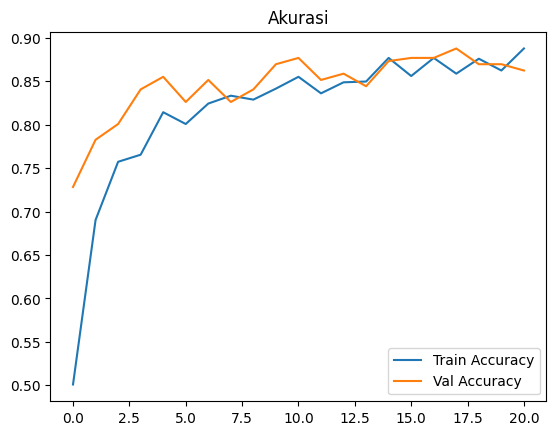

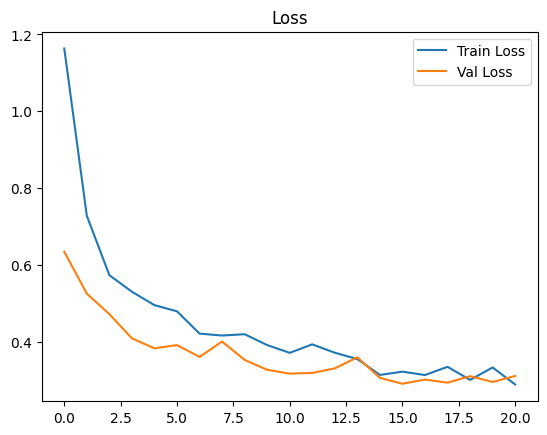

In [20]:
# === 8. Visualisasi Akurasi dan Loss ===
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Akurasi')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()


In [ ]:
# === 9. Simpan Model ===
MODEL_PATH = os.path.join(BASE_DIR, "mobilenetv2_model.h5")
model.save(MODEL_PATH)
print(f"Model disimpan di: {MODEL_PATH}")